# Load libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import Sequential, layers

2024-07-30 23:29:08.760664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 23:29:09.664256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Classifying smiles in SMILES dataset

## Loading the data

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory="Data/SMILES/", 
                                                       label_mode="binary",
                                                       color_mode="grayscale",
                                                       batch_size=64,
                                                       image_size=(64, 64),
                                                       seed=2023,
                                                       validation_split=0.2,
                                                       subset="training")
print(len(train_ds))

Found 13165 files belonging to 2 classes.
Using 10532 files for training.
165


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(directory="Data/SMILES/",
                                                     label_mode="binary",
                                                     color_mode="grayscale",
                                                     batch_size=64,
                                                     image_size=(64, 64),
                                                     seed=2023,
                                                     validation_split=0.2,
                                                     subset="validation")
print(len(val_ds))

Found 13165 files belonging to 2 classes.
Using 2633 files for validation.
42


In [4]:
class_names = train_ds.class_names
print(class_names)


['negatives', 'positives']


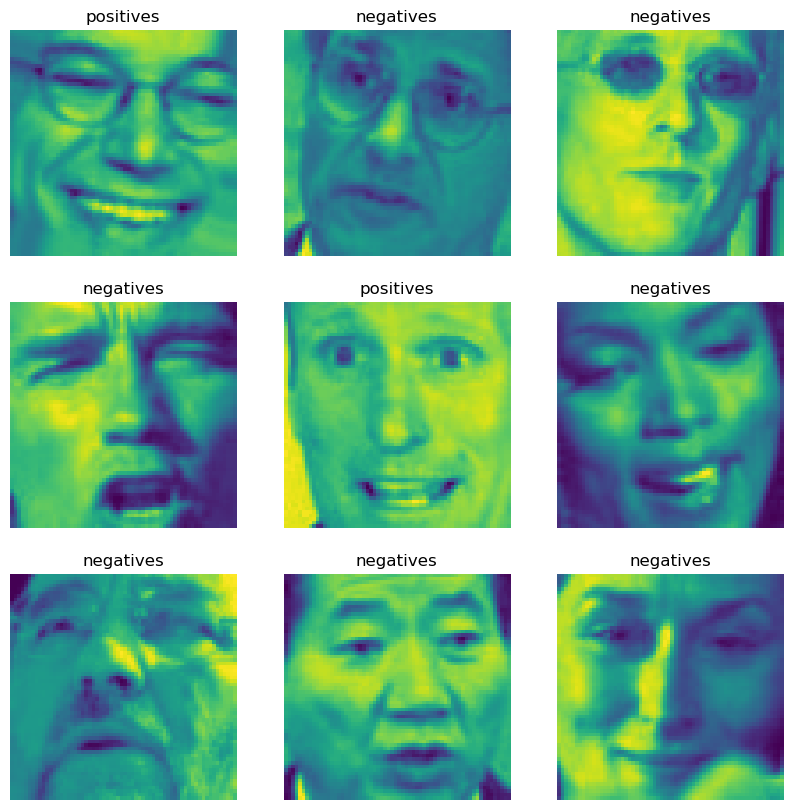

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")


In [6]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(64, 64, 64, 1)
(64, 1)


## Configure the dataset for performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [8]:
model = Sequential([layers.InputLayer(input_shape=(64, 64, 1)),
                    layers.Rescaling(1./255),
                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Dropout(0.2),
                    layers.Flatten(),
                    layers.Dense(128, activation='sigmoid'),
                    layers.Dense(1)])


## Compile the model

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

## Train the model

In [11]:
epochs = 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/20
165/165 [==============================] - 7s 37ms/step - loss: 0.4812 - accuracy: 0.7679 - val_loss: 0.3099 - val_accuracy: 0.8511
Epoch 2/20
165/165 [==============================] - 6s 35ms/step - loss: 0.2766 - accuracy: 0.8806 - val_loss: 0.2568 - val_accuracy: 0.8959
Epoch 3/20
165/165 [==============================] - 6s 35ms/step - loss: 0.2425 - accuracy: 0.8996 - val_loss: 0.2416 - val_accuracy: 0.9024
Epoch 4/20
165/165 [==============================] - 6s 36ms/step - loss: 0.2266 - accuracy: 0.9068 - val_loss: 0.2327 - val_accuracy: 0.9047
Epoch 5/20
165/165 [==============================] - 6s 37ms/step - loss: 0.2103 - accuracy: 0.9132 - val_loss: 0.2214 - val_accuracy: 0.9126
Epoch 6/20
165/165 [==============================] - 6s 37ms/step - loss: 0.1996 - accuracy: 0.9176 - val_loss: 0.2105 - val_accuracy: 0.9153
Epoch 7/20
165/165 [==============================] - 6s 36ms/step - loss: 0.1901 - accuracy: 0.9210 - val_loss: 0.2040 - val_accuracy: 0.9149

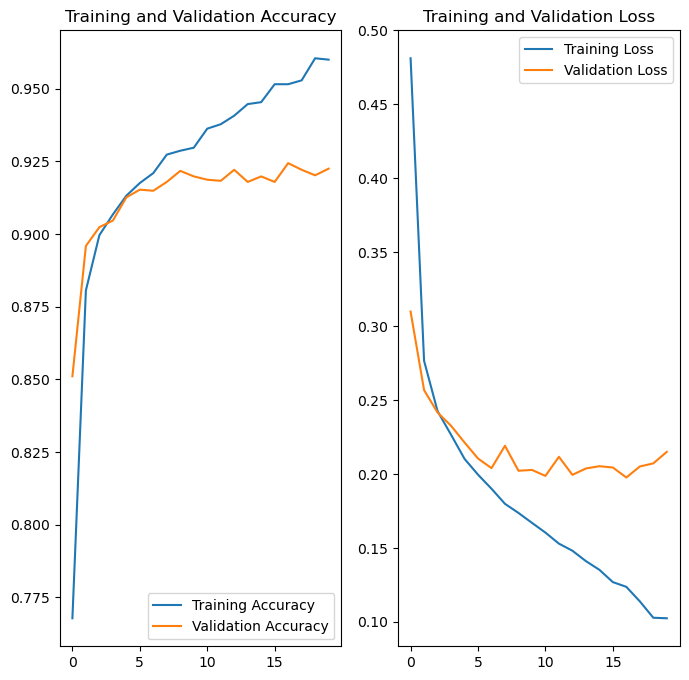

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Save the model

In [13]:
model.save("models/base_smile_cnn_20.h5")

## Evaluate the model

In [14]:
model.evaluate(val_ds, )

42/42 [==============================] - 0s 11ms/step - loss: 0.2150 - accuracy: 0.9225


[0.21500809490680695, 0.9225218296051025]